## Analysis of Telecom Churn Data Using Random Forest


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler

## Telecom Data

###  Details about the data
    
    This is a telecom dataset detailing the previous history of the customers who have either churn from the company or not. 
    This dataset is a classified dataset and having the label in the label column.
    
    This Dataset consists of 36 Columns regarding the customer like Mobile Number(MSISDN), billing details like recharge
    history, rental details, loan details and loan payback details of the customer.
    
    Below are the columns of the Dataset:
    label              msisdn                  aon                     daily_decr30            daily_decr90            
    rental30           rental90                last_rech_date_ma       last_rech_date_da       last_rech_amt_ma        
    cnt_ma_rech30      fr_ma_rech30            sumamnt_ma_rech30       medianamnt_ma_rech30    medianmarechprebal30    
    cnt_ma_rech90      fr_ma_rech90            sumamnt_ma_rech90       medianamnt_ma_rech90    medianmarechprebal90    
    cnt_da_rech30      fr_da_rech30            cnt_da_rech90           fr_da_rech90            
    cnt_loans30        amnt_loans30            maxamnt_loans30         medianamnt_loans30      
    cnt_loans90        amnt_loans90            maxamnt_loans90         medianamnt_loans90      
    payback30          payback90               pcircle                 pdate 
    
###### Total No of records available in the file is 209594.
    
### Analysis of Data

   Loading the data from CSV file to pandas table: 

In [2]:
data = pd.read_csv('telecom_churn.csv')

Check if Null data exist. We can see that there is no null data in the file.

In [28]:
#Check if null data exist in dataframe
print(data.isnull().sum())


,0
aon,0
daily_decr30,0
daily_decr90,0
rental30,0
rental90,0
last_rech_date_ma,0
last_rech_date_da,0
last_rech_amt_ma,0
cnt_ma_rech30,0
fr_ma_rech30,0


In [4]:
#Separate the output label from input data set
labels = data.iloc[:,0]
data.drop(['label'],axis=1,inplace=True)

#Remove the string data which is not useful for the calculation
data.drop(['msisdn', 'pcircle', 'pdate'],axis=1,inplace=True)

### Get Statistics from the Data

    Calculating the correlation and data stats to understand the outliers and proceed towards the data preprocessing.

In [5]:
def getStats(data): 
    corr = data.corr() 
    #Getting stats from Data
    stats = data.describe()
    #Getting additional stats from Data for outlier detection
    statsExtra = data.aggregate([iqr,bottomRange,upperRange])
    statsExtra.index = ['IQR','outlier_bottom_range','outlier_upper_range']
    return pd.concat([stats, statsExtra]),corr

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

def bottomRange(x):
    return x.quantile(0.25) - 1.5 * iqr(x)

def upperRange(x):
    return x.quantile(0.75) + 1.5 * iqr(x)

stats,corr = getStats(data)
stats

,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,...,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90
count,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.00000,209593.000000,209593.000000,209593.000000,209593.000000,...,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000,209593.000000
mean,8112.343445,5381.402289,6082.515068,2692.581910,3483.406534,3755.84780,3712.202921,2064.452797,3.978057,3737.355121,...,2.758981,17.952021,274.658747,0.054029,18.520919,23.645398,6.703134,0.046077,3.398826,4.321485
std,75696.082531,9220.623400,10918.812767,4308.586781,5770.461279,53905.89223,53374.833430,2370.786034,4.256090,53643.625172,...,2.554502,17.379741,4245.264648,0.218039,224.797423,26.469861,2.103864,0.200692,8.813729,10.308108
min,-48.000000,-93.012667,-93.012667,-23737.140000,-24720.580000,-29.00000,-29.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,246.000000,42.440000,42.692000,280.420000,300.260000,1.00000,0.000000,770.000000,1.000000,0.000000,...,1.000000,6.000000,6.000000,0.000000,1.000000,6.000000,6.000000,0.000000,0.000000,0.000000
50%,527.000000,1469.175667,1500.000000,1083.570000,1334.000000,3.00000,0.000000,1539.000000,3.000000,2.000000,...,2.000000,12.000000,6.000000,0.000000,2.000000,12.000000,6.000000,0.000000,0.000000,1.666667
75%,982.000000,7244.000000,7802.790000,3356.940000,4201.790000,7.00000,0.000000,2309.000000,5.000000,6.000000,...,4.000000,24.000000,6.000000,0.000000,5.000000,30.000000,6.000000,0.000000,3.750000,4.500000
max,999860.755200,265926.000000,320630.000000,198926.110000,200148.110000,998650.37770,999171.809400,55000.000000,203.000000,999606.368100,...,50.000000,306.000000,99864.560860,3.000000,4997.517944,438.000000,12.000000,3.000000,171.500000,171.500000
IQR,736.000000,7201.560000,7760.098000,3076.520000,3901.530000,6.00000,0.000000,1539.000000,4.000000,6.000000,...,3.000000,18.000000,0.000000,0.000000,4.000000,24.000000,0.000000,0.000000,3.750000,4.500000
outlier_bottom_range,-858.000000,-10759.900000,-11597.455000,-4334.360000,-5552.035000,-8.00000,0.000000,-1538.500000,-5.000000,-9.000000,...,-3.500000,-21.000000,6.000000,0.000000,-5.000000,-30.000000,6.000000,0.000000,-5.625000,-6.750000


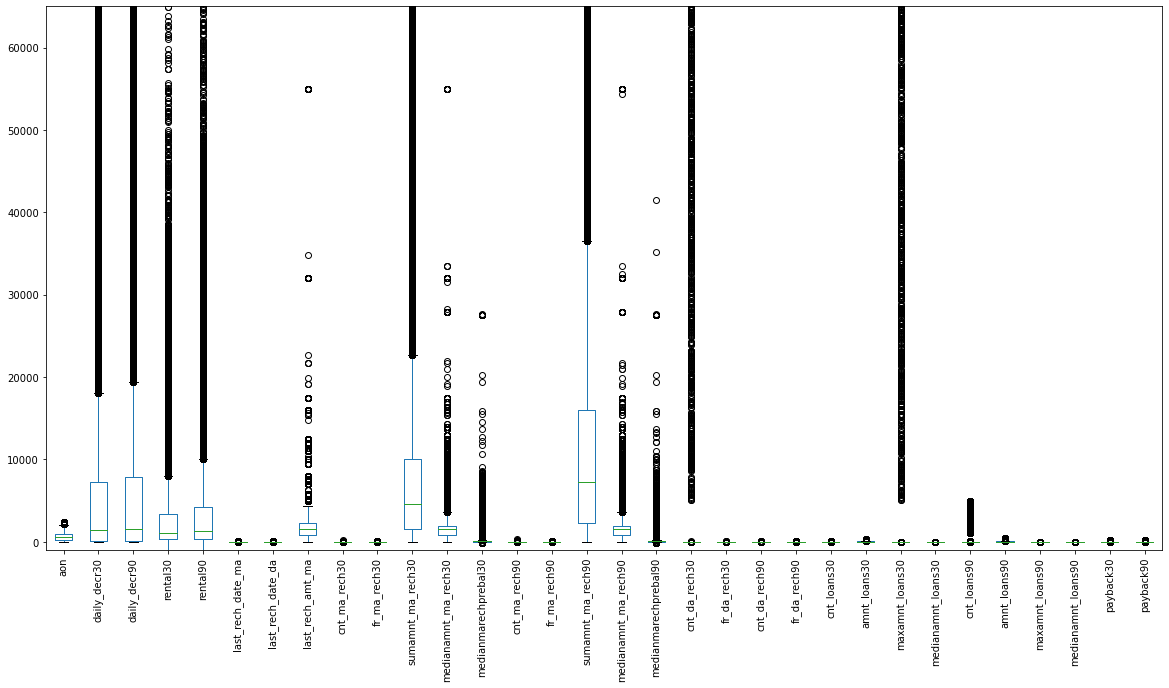

In [6]:
data.plot.box(figsize=(20,10),rot=90,ylim=[-1000,65000])

#### Outlier Transformation:

    * Several changes were made to the dataset to prepare it for analysis. As there are no null values in the data set 
      there is no need to perform any null value imputation for the data set. There are outliers for many variables in the 
      data set.
    * For this data set I simply choose mean for imputing the outliers with the respective features. After performing mean, 
      I also applied cube root for the data to bring data closer as to make the distribution normal.
    * So, outlier imputation is far better than simply removing the outliers from the data. As the data set belongs to the 
      loan defaulters or not the outliers are also important for us to get the unbiased results after performing 
      machine learning algorithms.

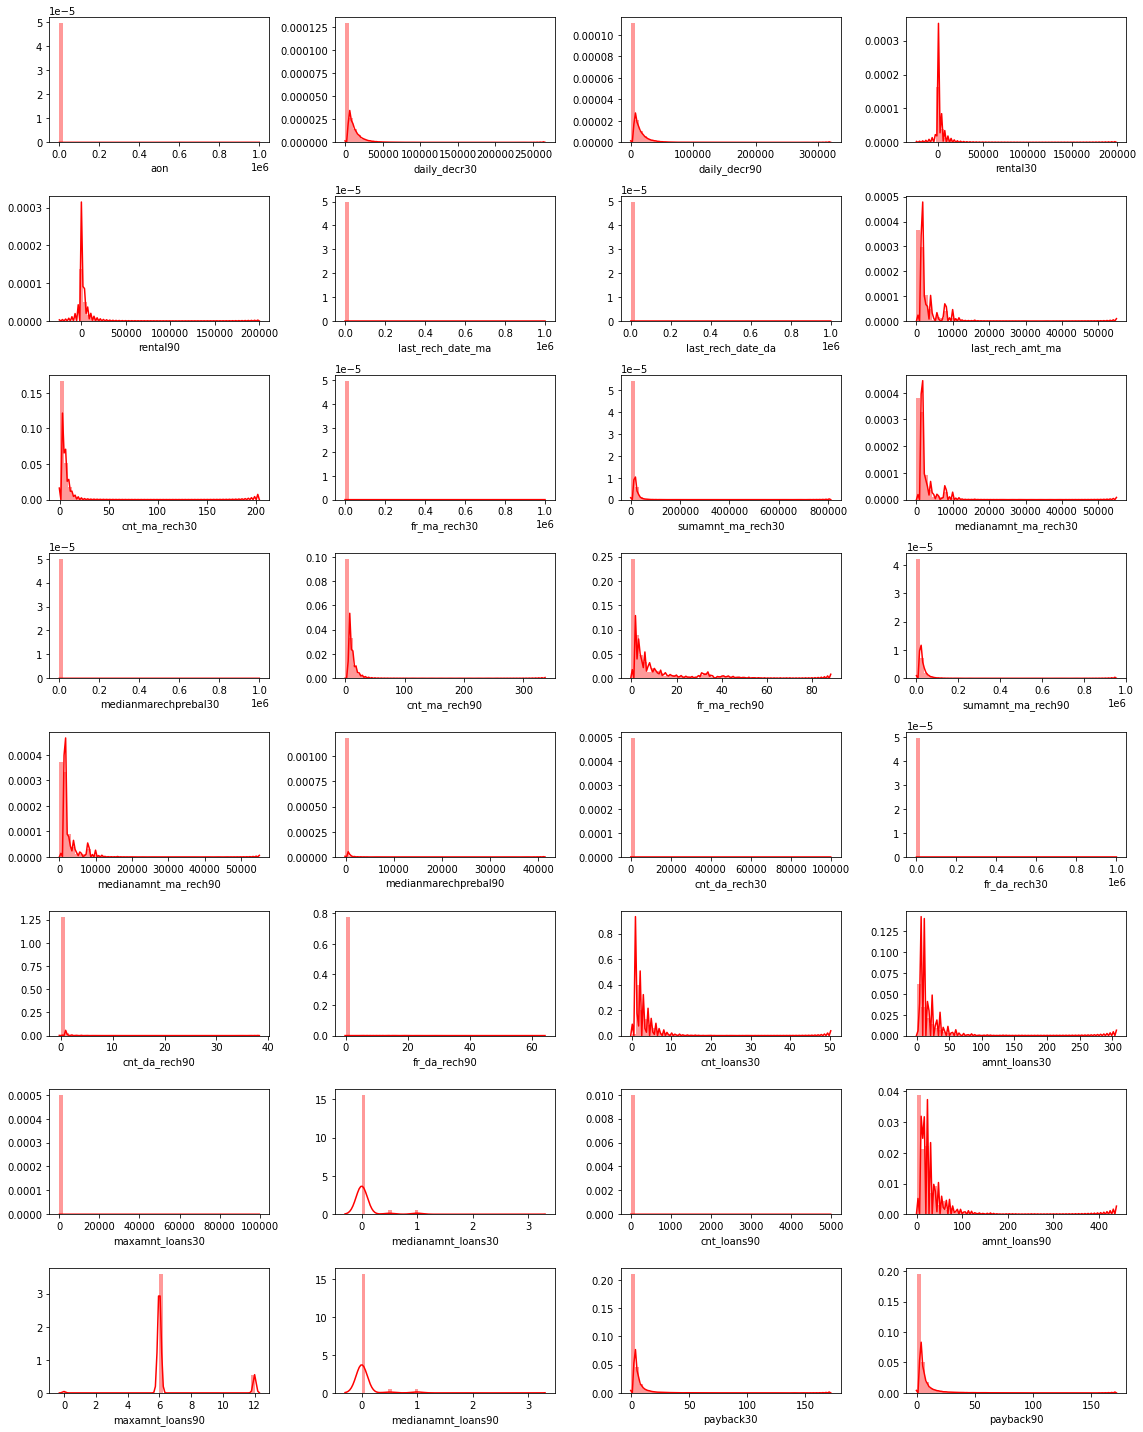

In [7]:
columns = data.columns

fig,ax = plt.subplots(8,4,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(data[col],ax=ax[i],color='red',kde_kws={'bw':0.1})
plt.tight_layout()
plt.show()

In [8]:
## For Data which is not satisfing : -3 < zscore < 3  is replaced with median and also cuberoot is done 
## to make data normally distributed. 

for i in range(len(columns)):
    data[columns[i]]=zscore(data[columns[i]])
    for j in range(len(data[columns[i]])):
        if data[columns[i]][j]>3 or data[columns[i]][j]<-3:
            data[columns[i]].replace(data[columns[i]][j],data[columns[i]].median(),inplace=True)
    data[columns[i]]=np.cbrt((data[columns[i]]))
    

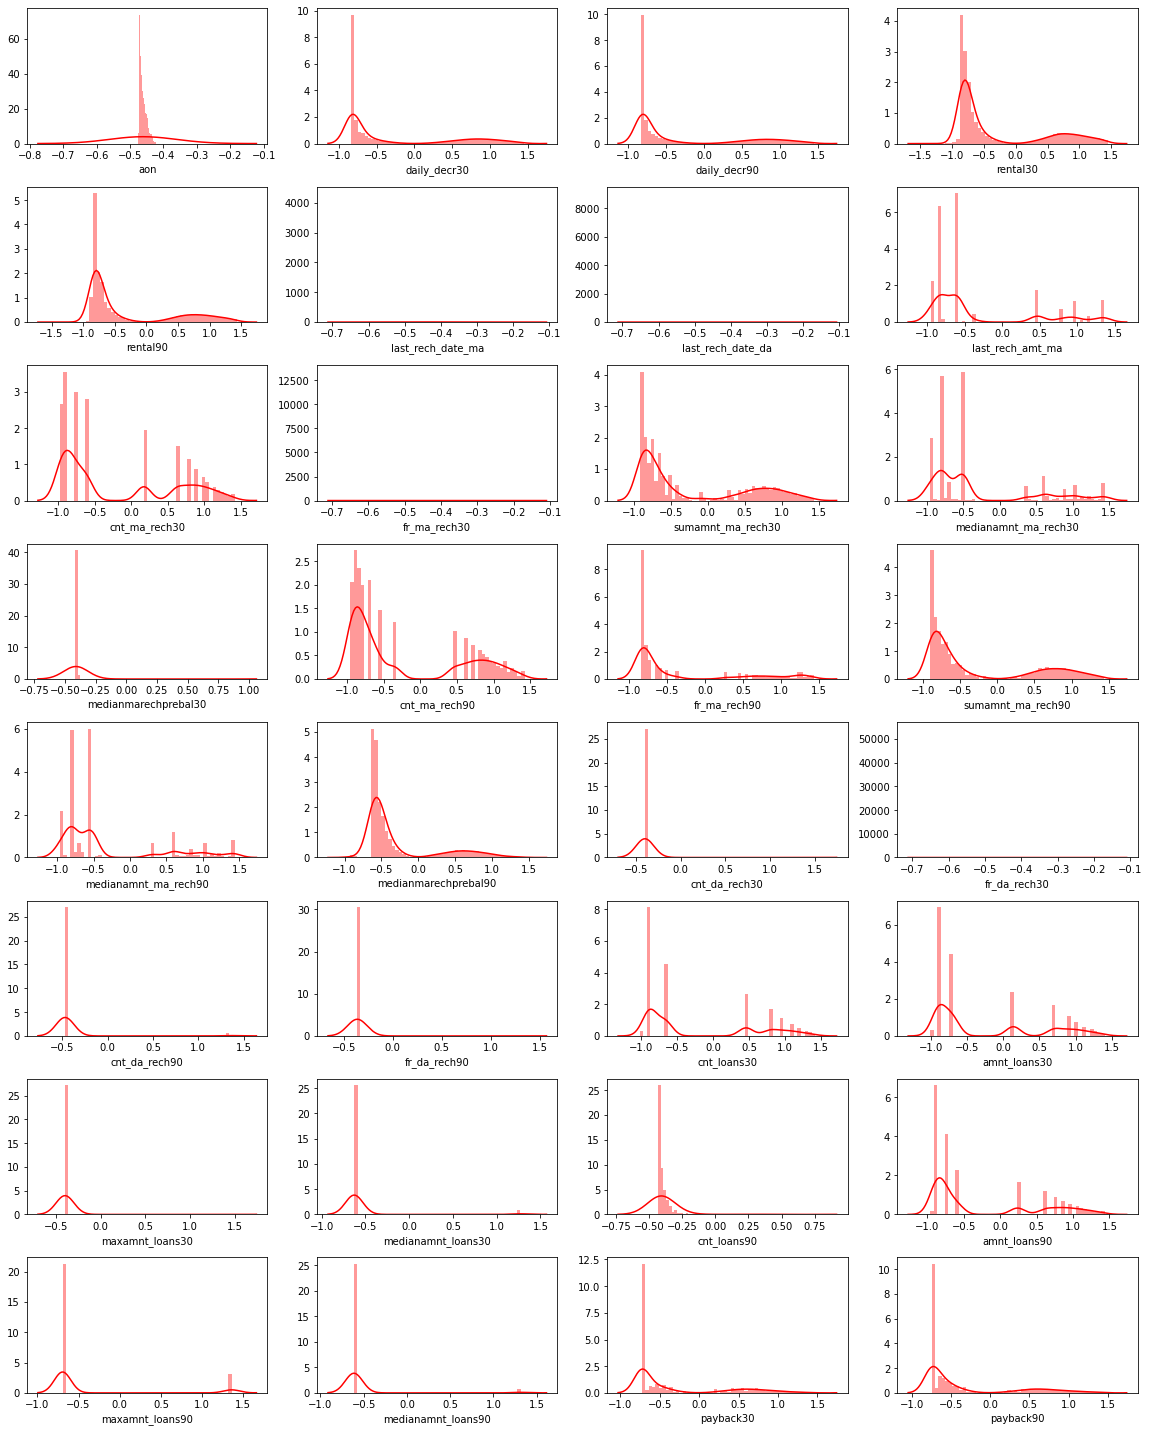

In [9]:
# After normalizing the data below is the view of data for different columns.

fig,ax = plt.subplots(8,4,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(data[col],ax=ax[i],color='red',kde_kws={'bw':0.1})
plt.tight_layout()
plt.show()

###### Applied Principal Component Analysis to reduce the dimensionality of the data, eliminate the problem of multicollinearity and improve the predictive power of the models

In [10]:
pca = PCA(n_components=13)
pca.fit(data)
data_pca = pd.DataFrame(pca.transform(data))
data_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1.317369,-0.478951,-0.575454,2.397262,-0.935696,0.188606,-0.792507,0.938883,-0.284819,0.091649,-0.217451,-0.054349,-0.005137
1,0.376630,3.205119,1.223947,0.313108,0.047349,-1.768409,0.886548,-0.082874,0.123731,-0.684481,-0.258148,0.681419,0.158124
2,-2.013359,-0.059871,0.169447,-0.469874,0.009245,-0.392086,-0.016005,-0.185076,-0.060666,0.023243,-0.041141,-0.023359,0.065832
3,-2.059540,-0.608705,0.155077,-0.449883,-0.051500,-0.396079,0.156880,-0.306729,-0.253967,0.066931,0.007668,-0.077045,-0.081890
4,2.328159,0.264414,-2.431849,-0.996839,1.064115,0.085948,0.048846,-0.241062,-0.547807,-0.032977,0.137404,-0.308970,0.178096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209588,-0.778444,2.034025,-1.207943,-0.600083,0.705766,-0.381810,-0.383350,0.082498,-0.169439,0.219733,-0.135284,0.173737,-0.101451
209589,-0.653783,-1.199493,-0.430239,-0.563887,0.469779,0.044971,0.371035,-0.202918,0.768340,0.224642,-0.237312,0.436766,0.076155
209590,3.750996,-0.577959,1.239195,0.189288,-0.006415,-0.424833,1.098336,0.391034,-0.321864,0.060853,-0.015298,-0.088891,0.050225
209591,1.770430,0.504857,0.214961,-0.519012,-1.784762,-0.774547,0.515795,1.187945,0.099475,0.715087,-0.237547,0.202301,0.584062


#### Model fitting using Random Forest and comparing the results with Decision Tree.

Generic Classifier written to handle model fitting and predicting the Accuracy, True Positive Rate, Precision. 
Calling process data will handle all of the inner processes

In [11]:
class Classifier:
    cm = {}
    #Processes the data by reprocessing and removing outlier and running prediction by given inputs
    def ProcessData(self,input,label,model,foldSplit=1,display='default') :
        input = self.preprocess_data(input)
        return self.ModelPredict(input,label,model,foldSplit,display)

    #This is the method for preprocessing of the data
    def preprocess_data(self,data) :
        names = data.columns
        scaler = MinMaxScaler()
        return  pd.DataFrame(scaler.fit_transform(data), columns=names)
  
    #This is the predection logic This also returns the accuracy, True positive rate, precision
    def ModelPredict(self,inputData,target,model,foldSplit,display) :
        #Train Test Split
        result = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
        if foldSplit > 1 :
            cross_val = KFold(n_splits=foldSplit)
            foldNumber = 1
            for train_index, test_index in cross_val.split(inputData):
                #print(train_index,test_index)
                train_example, test_example, train_label, test_label = inputData.iloc[train_index], inputData.iloc[test_index], target.iloc[train_index], target.iloc[test_index]
                result=result.append(pd.Series(self.run(train_example,train_label,test_example,test_label,model),name=('Fold= '+str(foldNumber))))
                foldNumber = foldNumber + 1    
        else:
            train_example, test_example, train_label, test_label = train_test_split(inputData,target,stratify=target)
            result=result.append(pd.Series(self.run(train_example,train_label,test_example,test_label,model),name=('Model= '+model)))  
        
        sns.heatmap(self.cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.show()
        return result
                           
    #Generic logic to predict and get result
    def run(self,train_example,train_label,test_example,test_label,model):
        
        #Model Fitting
        model.fit(train_example,np.ravel(train_label,order='C'))
    
        #Prediction
        test_prediction = model.predict(test_example)
        
        #Prediction Evaluation by Accuracy, True Positive Rate, Precision
        accuracy = accuracy_score(test_label,test_prediction)
        truePositiveRate=recall_score(test_label,test_prediction,pos_label=1)
        precision = precision_score(test_label,test_prediction,pos_label=1)
        self.cm = confusion_matrix(test_label, test_prediction)
        return {'Accuracy':accuracy*100,'True Positive Rate':truePositiveRate*100,'Precision':precision*100}
        
    def buildDataReport(self,result,title,xlabel="Runs",ylabel="Score",shape=(20,5),lineNeeded=False,barNeeded=True):
        
        fig = plt.gcf()
        fig.set_size_inches(shape)
        #colors = plt.cm.BuPu(np.linspace(0, 0.5, len(result.index)))
        w=0.25
        
        accuracyBar = np.arange(len(result.index))
        truePositiveBar = [i+w for i in accuracyBar]
        precisionBar = [i+w for i in truePositiveBar]
        if barNeeded:
            plt.bar(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.bar(truePositiveBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.bar(precisionBar,result.iloc[:,2],w,label="precision",color='orange') 
            
        
        if lineNeeded :
            plt.plot(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.plot(accuracyBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.plot(accuracyBar,result.iloc[:,2],w,label="precision",color='orange')
            w=0
        
        plt.ylim([0,100])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(accuracyBar+w,result.index,rotation=45)
        plt.title(title)
        plt.legend()
        plt.show()
        
    def compareModelData(self,series1,series2,label1,label2):
        fig = plt.gcf()
        fig.set_size_inches((20,5))
        w=0.25
        model1Bar = np.arange(len(series1.index))
        model2Bar = [i+w for i in model1Bar]

        plt.bar(model1Bar,series1,w,label=label1,color='blue')
        plt.bar(model2Bar,series2,w,label=label2,color='green')

        finalResult = series1.to_frame()
        finalResult.columns=[label1]
        finalResult[label2] = series2

        plt.xticks(model1Bar+(w/2),finalResult.index)
        plt.title('Result Comparision '+(label1+','+label2))
        plt.legend()
        plt.show()
        return finalResult

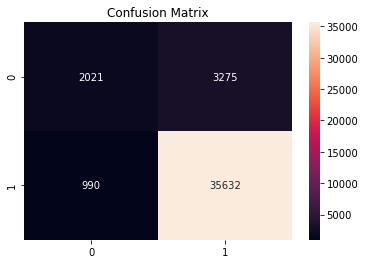

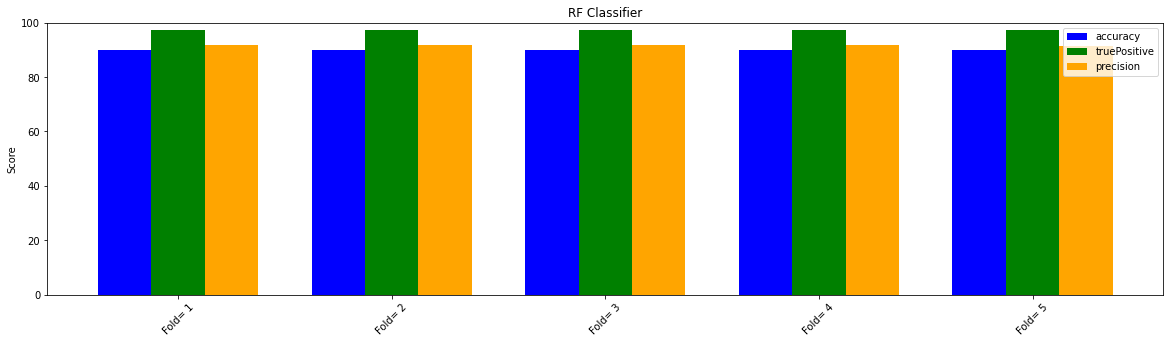

,Accuracy,True Positive Rate,Precision
Fold= 1,89.930580,97.309613,91.683377
Fold= 2,89.870942,97.298329,91.642059
Fold= 3,89.878098,97.256804,91.689352
Fold= 4,89.978052,97.152570,91.887234
Fold= 5,89.825373,97.296707,91.582492


In [12]:
# Run Model Fitting with KFOLD and present data for Random forest
classifier  = Classifier()
RF = RandomForestClassifier(criterion='entropy',n_estimators=50,random_state=0)
op = classifier.ProcessData(data_pca,labels,RF,foldSplit=5)
classifier.buildDataReport(op,"RF Classifier",xlabel='',lineNeeded=False,barNeeded=True)
op

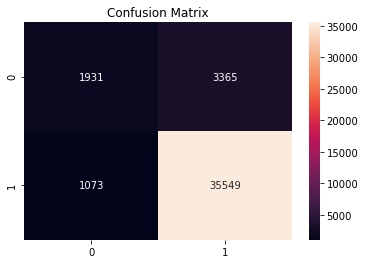

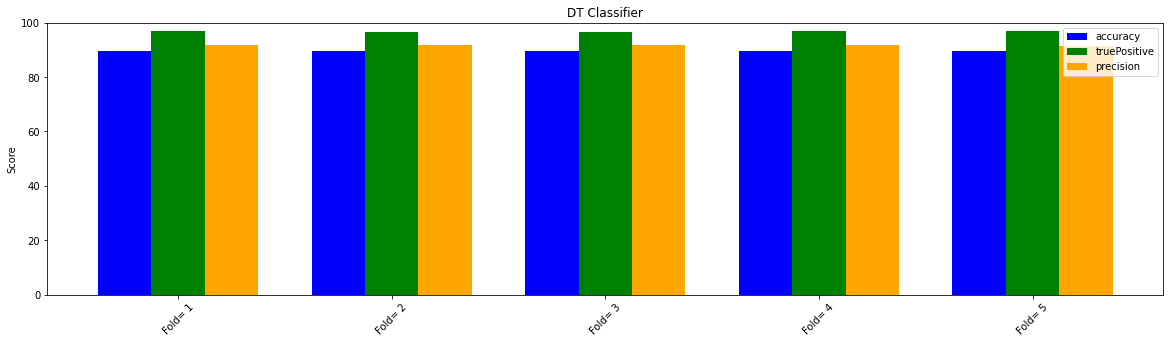

,Accuracy,True Positive Rate,Precision
Fold= 1,89.486868,96.837567,91.615468
Fold= 2,89.432000,96.594967,91.761842
Fold= 3,89.465398,96.763736,91.669462
Fold= 4,89.739491,97.032907,91.745738
Fold= 5,89.412663,97.070067,91.352727


In [13]:
# Run Model Fitting with KFOLD and present data for Decision Tree
classifier = Classifier()
DT = DecisionTreeClassifier(criterion='gini',max_depth=14,min_samples_leaf=19,random_state=0)
op1 = classifier.ProcessData(data_pca,labels,DT,foldSplit=5)
classifier.buildDataReport(op1,"DT Classifier",xlabel='',lineNeeded=False,barNeeded=True)
op1

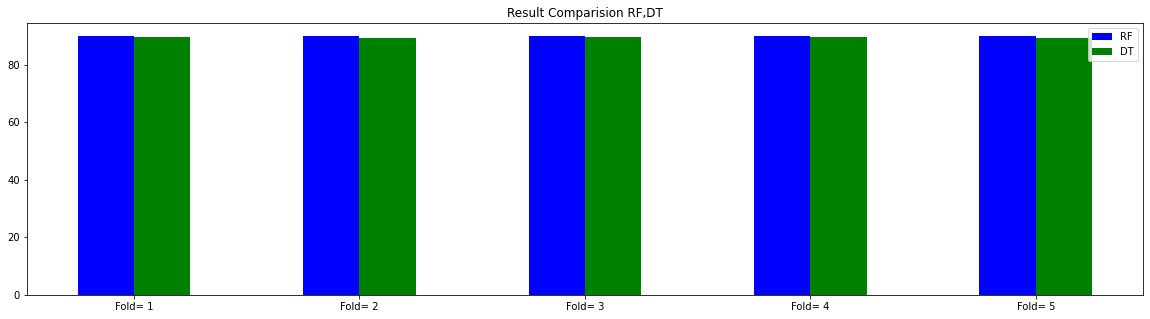

,RF,DT
Fold= 1,89.930580,89.486868
Fold= 2,89.870942,89.432000
Fold= 3,89.878098,89.465398
Fold= 4,89.978052,89.739491
Fold= 5,89.825373,89.412663


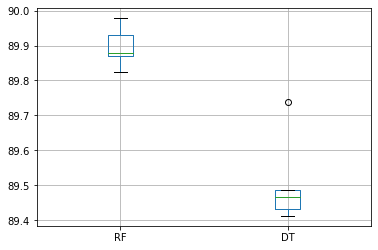

In [17]:
#Comparing the result from Random Forest with Decision Tree
compareObj = Classifier().compareModelData(op.iloc[:,0],op1.iloc[:,0],"RF","DT")
compareObj.boxplot()
compareObj

###### We can see that Random forest is performing better than the decision Tree. Above plot of model prediction results from Decision Tree and Random forest for the same data set.